<a href="https://colab.research.google.com/github/vashic/Object-Detection/blob/master/ImageToChip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This lesson is to convert annotation over large GeoTiffs made on QGIS in the form of rectangular polygon GeoJSONS to YOLO readable ones. We will also split the images into 512x512 sides chips to ready it for training. Some level of preprocessing is required on QGIS before we can start with this tutorial which is essentially the annotations themselves. QGIS provides the option of creating vector files which is detailed in [this simple tutorial](https://www.qgistutorials.com/en/docs/digitizing_basics.html) by [Ujaval Gandhi](https://spatialthoughts.com/about/). I annotated the imagery usig a rectangular polygon for simplicity. The created vector files can be exported as a GeoJSON file (Right click on the saved layer>Export. However, when we are working with very large areas, we might have used multiple images for the digitization procedure. For the sake of this tutorial, we will not have to worry about it as we are using a single image. However, for the curious, there are two ways by which to handle it:
* Technqiue 1: This is the better way which I'll update the codes for subsequently. We need to create a field containing the path of the image we have used for the digitization so that we can call the specific image for chip generation.
* Technique 2: Not a recommended technique due to the huge sizes of the resulting dataset, but you can mosaic all the images to generate one giant image that can be used with this code for chipping.

The image and the geojson created on the image is uploaded into a Directory on your Google Drive. I have called the Directory CraterDetection. Now we're ready to start with our tutorial. First step is to import Drive where our data is stored. The first two commands are sufficient to mount Drive. However, I am creating a symbolic link to the Directory I am using using the ln command accessed via bash (using !).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ln -s /content/gdrive/My\ Drive/CraterDetection /content/crater
!ls /content/crater

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
B19_016892_1884_XN_08N297W.tiff  dataset1   testIm.tif	      trial.geojson
CraterDetection			 dataset2   testIm_write.tif
dataset				 RawImages  train.json


Next, we'll import a whole bunch of libraries that we will be using. Certain libraries aren't available on Colab and can be installed using the pip install command by accessing bash through the ! 

The list of libraries and their functions are as follows:
* geojson used to load, encode and decode geojsons.
* glob can be used to find files in the directory
* rasterio
* matplotlib

In [ ]:
import glob
image_folder = '/content/crater'
# The geojson file is searched for in the directory using the glob function which returns a list. The first element of the list is accessed which is the file in question.
fileg=glob.glob(image_folder+'/*.geojson')[0]
print(fileg)

/content/crater/trial.geojson


In order to open and work with the geojson file, we will need to import the geojson library. As it isn't available by default on colab, we will install it using the pip installation by accessing bash.

In [ ]:
!pip install geojson
import geojson
# reading GEOJSON files
with open(fileg, 'r') as f:
    labelg = geojson.load(f)

Now we have the annotated labels in the geojson file stored in the labelg variable. On checking the datatype, you see that its a geojson Feature Collection. You can view its keys using the .keys()

In [ ]:
#Checking the datatype of the variable labelg
type(labelg)

geojson.feature.FeatureCollection

In [ ]:
print('GeoJSON keys: ',labelg.keys())

GeoJSON keys:  dict_keys(['type', 'name', 'features'])


You can explore the different features and their contents by accessing the values for the keys.

In [ ]:
#Accessing the type key
print('Type is:',labelg['type'])
#Accessing the name key
print('Name is:',labelg['name'])
#Accessing the features key
print('Features are:',labelg['features'])

Type is: FeatureCollection
Name is: trial
Features are: [{"geometry": {"coordinates": [[[[169.493128, 18.909745], [169.493128, 19.638177], [170.22, 19.638177], [170.22, 18.909745], [169.493128, 18.909745]]]], "type": "MultiPolygon"}, "properties": {"id": 1}, "type": "Feature"}, {"geometry": {"coordinates": [[[[170.723819, 18.610262], [170.723819, 18.809917], [170.95935, 18.809917], [170.95935, 18.610262], [170.723819, 18.610262]]]], "type": "MultiPolygon"}, "properties": {"id": 2}, "type": "Feature"}, {"geometry": {"coordinates": [[[[171.075556, 20.5959], [171.075556, 20.723025], [171.218278, 20.723025], [171.218278, 20.5959], [171.075556, 20.5959]]]], "type": "MultiPolygon"}, "properties": {"id": 3}, "type": "Feature"}, {"geometry": {"coordinates": [[[[169.525884, 20.318254], [169.525884, 20.445378], [169.659248, 20.445378], [169.659248, 20.318254], [169.525884, 20.318254]]]], "type": "MultiPolygon"}, "properties": {"id": 4}, "type": "Feature"}, {"geometry": {"coordinates": [[[[171.12

So you see that the geojson contains a FeatureCollection named trial (recall that the filename is trial.geojson). A featurecollection is a list of features. The features within the feature collection can further be explored.

In [ ]:
#Checking the datatype of features
print(type(labelg['features']))

<class 'list'>


In [ ]:
#Accessing elements
print(labelg['features'][0])

{"geometry": {"coordinates": [[[[169.493128, 18.909745], [169.493128, 19.638177], [170.22, 19.638177], [170.22, 18.909745], [169.493128, 18.909745]]]], "type": "MultiPolygon"}, "properties": {"id": 1}, "type": "Feature"}


Each of the features are given by a key value pair. Let's see what the keys are:

In [ ]:
#Getting the list of keys
print(labelg['features'][0].keys())

dict_keys(['type', 'geometry', 'properties'])


In [ ]:
# Accessing the values of the first feature
print('Type is:',labelg['features'][0]['type'])
print('Geometry is:',labelg['features'][0]['geometry'])
print('Properties is:',labelg['features'][0]['properties'])

Type is: Feature
Geometry is: {"coordinates": [[[[169.493128, 18.909745], [169.493128, 19.638177], [170.22, 19.638177], [170.22, 18.909745], [169.493128, 18.909745]]]], "type": "MultiPolygon"}
Properties is: {'id': 1}


In [ ]:
#Let's see how this varies for the next feature
print('Type is:',labelg['features'][1]['type'])
print('Geometry is:',labelg['features'][1]['geometry'])
print('Properties is:',labelg['features'][1]['properties'])

Type is: Feature
Geometry is: {"coordinates": [[[[170.723819, 18.610262], [170.723819, 18.809917], [170.95935, 18.809917], [170.95935, 18.610262], [170.723819, 18.610262]]]], "type": "MultiPolygon"}
Properties is: {'id': 2}


All of the Features represent the coordinates of the bounding rectangle given by left bottom, left top, right top and right bottom. The coordinates are as available for the image stored in our directory. Let's take a look at the image. In order to open the image, we need to use a library that is compatible with the Geotiff format which is the format of our image. GDAL is a commonly used Python library for raster analysis. Rasterio is another tool built over GDAL which provides a Pythonic wrapper around GDAL. We'll use rasterio here.

In [ ]:
!pip install rasterio
import rasterio as rst
import numpy as np
dataset=rst.open(image_folder+'/'+'testIm.tif')

     |████████████████████████████████| 18.2MB 230kB/s 


In [ ]:
# RasterYSize to get the number of rows, RasterXSize to get the number of columns and RasterCount to get bands
num_rows,num_cols = dataset.shape
num_bands = dataset.count

print('Image size is: {r} rows x {c} columns x {b} bands \n'.format(r=num_rows, c=num_cols, b=num_bands))

Image size is: 321 rows x 313 columns x 1 bands 



Let's also see the Coordinate Reference System, Geotransform and Metadata of the dataset

In [ ]:
crs=dataset.crs
transform=dataset.transform
metadata=dataset.meta
description=dataset.descriptions
print('CRS:',crs)
print('\n Geotransform:',transform)
print('\n Metadata:',metadata)
print('\n Description:',description)

CRS: GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",3396190,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]

 Geotransform: | 0.01, 0.00, 168.26|
| 0.00,-0.01, 21.00|
| 0.00, 0.00, 1.00|

 Metadata: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 313, 'height': 321, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",3396190,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]]'), 'transform': Affine(0.009967795501597375, 0.0, 168.26006,
       0.0, -0.009968847398753896, 21.000000015)}

 Description: (None,)


In order to read the bands as a numpy array, use the read function

In [ ]:
print('Image type is:',type(dataset))
data_as_arr=dataset.read(1) #Note that the one in the bracket refers to the band we are reading. GDAL is 1 indexed, not the Pythonic 0 based index. We can also read all bands by not specifying a number which will be the same as 1 in this case
print('\nImage type after reading is:',type(data_as_arr))

Image type is: <class 'rasterio.io.DatasetReader'>

Image type after reading is: <class 'numpy.ndarray'>


Let's try some numpy commands on the data and try to visualize the data using matplotlib

In [ ]:
print(data_as_arr.shape)

(321, 313)


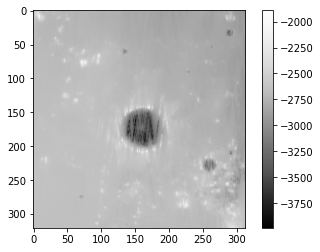

In [ ]:
#Importing required libraries
import matplotlib.pyplot as plt

# Plotting in greyscale
plt.imshow(data_as_arr[:,:],cmap=plt.cm.Greys_r)
plt.colorbar()

The geojson annotations now need to be converted into a YOLO readable text file. YOLO requires a list of the central coordinates, the bounding box bottom left and top right coordinates. We can extract the centers and the coordinates for each feature using the coordinates key under geometry key of the feature.

In [ ]:
# extracting coordinates of bounding boxes
coords, center_list = [], []
for p in range(0,len(labelg['features'])):
  [[[[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x5,y5]]]]=(labelg['features'][p]['geometry']['coordinates'])
  x_bot=min(x1,x2,x3,x4)
  y_bot=min(y1,y2,y3,y4)
  x_top=max(x1,x2,x3,x4)
  y_top=max(y1,y2,y3,y4)
  #Stores the bb centre coordinates
  center_list.append([(x_bot+x_top)//2, (y_bot+y_top)//2])
  #Stores the bb bottom left and top right
  q=[[x_bot,y_bot],[x_top,y_top]]
  coords.append(q)
#coords = np.array(coords)
print(type(coords))
print(type(center_list))
print(coords)
print(center_list)
coords = np.array(coords)


<class 'list'>
<class 'list'>
[[[169.493128, 18.909745], [170.22, 19.638177]], [[170.723819, 18.610262], [170.95935, 18.809917]], [[171.075556, 20.5959], [171.218278, 20.723025]], [[169.525884, 20.318254], [169.659248, 20.445378]], [[171.12235, 18.862171], [171.192542, 18.940161]], [[168.933546, 18.218749], [169.005688, 18.288161]]]
[[169.0, 19.0], [170.0, 18.0], [171.0, 20.0], [169.0, 20.0], [171.0, 18.0], [168.0, 18.0]]


We have extracted the centers of the bounding box and its coordinates as a Python list. Next, we will create clusters of the bounding box centers so that we chip only parts of the image containing bounding boxes as opposed to providing inputs of images without annotations. Min_samples is set to 1 implying that in case of a bounding box separate from others, it can be a cluster in itself ie the minimum number of samples required to form a cluster is 1. EPS is the maximum distance between two samples in a cluster. If it is low, then the clusters are smaller and there are more clusters. If it's high, then there are fewer clusters of a larger size. For our purposes with the trial image and annotations, I've set a low value for more clusters. For a well annotated image we can set it close to 256.

In [ ]:
# DB-Scan algorithm for clustering
# value of eps (threshold) can be set from 220-256 for images with a large number of annotations. 

from sklearn.cluster import DBSCAN
eps = 1
dbscan = DBSCAN(min_samples=1, eps=eps)
x = np.array(center_list)
y = dbscan.fit_predict(x)
print(y)

[0 1 2 0 1 3]


Now that we have clustered the annoatations and created a list y with the value of the index corresponding to the cluster the annotation belongs to (in this case we have the 6 annotations in 4 clusters 0,1,2 and 3). Let's now generate the centroids of the clusters and the bounding box of the cluster.

In [ ]:
# storing centroid of clusters
info = {}
for i in range(y.max()+1):
    # calculates the max and min coords of all the
    # bounding boxes present in the cluster
    mi_x, mi_y = x[np.where(y==i)[0]].min(axis=0)
    ma_x, ma_y = x[np.where(y==i)[0]].max(axis=0)

    item = {}
    item['center'] = [(mi_x+ma_x)//2, (mi_y+ma_y)//2]
    item['bbox'] = coords[np.where(y==i)[0]].tolist()

    info[i] = item

The info variable contains the cluster centers and bounding boxes.

In [ ]:
info

{0: {'bbox': [[[169.493128, 18.909745], [170.22, 19.638177]],
   [[169.525884, 20.318254], [169.659248, 20.445378]]],
  'center': [169.0, 19.0]},
 1: {'bbox': [[[170.723819, 18.610262], [170.95935, 18.809917]],
   [[171.12235, 18.862171], [171.192542, 18.940161]]],
  'center': [170.0, 18.0]},
 2: {'bbox': [[[171.075556, 20.5959], [171.218278, 20.723025]]],
  'center': [171.0, 20.0]},
 3: {'bbox': [[[168.933546, 18.218749], [169.005688, 18.288161]]],
  'center': [168.0, 18.0]}}

In [ ]:
info.keys()

dict_keys([0, 1, 2, 3])

In [ ]:
from imageio import imwrite

In [ ]:
# saves chips of size 512x512
# along with labels in YOLO format
def save_files(image, info):
    
    for k in info.keys():
        y, x = info[k]['center'][0], info[k]['center'][1] #Because of the way the centers are stored we have y coordinate first and then x
        x=int(x)
        y=int(y)
        if y<=10:
          continue
        elif x<=10:
          continue

        print('\n',k)
        # saving image chip
        iname = '/content/crater/data/im_{}.jpg'.format(k)
        #imwrite(iname, image[max((x-256), 0):min((x+256),image.shape[0]),max(0,(y-256)):min((y+256),image.shape[1])])
        imwrite(iname, image[x-10:x+10,y-10:y+10])

        # saving label
        file = open(iname.replace('.jpg', '.txt'), 'a')
        for point in info[k]['bbox']:
            [[x_bot, y_bot], [x_top, y_top]] = point
            xc = (x_bot+x_top)//2 - x + 10
            yc = (y_bot+y_top)//2 - y + 10
            w = abs(x_bot-x_top)
            h = abs(y_bot-y_top)

            # 0 means first object i.e. crater
            lab = '0 {} {} {} {}\n'.format(xc/20, yc/20, w/20, h/20)
            file.write(lab)
        file.close()

In [ ]:
save_files(data_as_arr,info)


 0

 1

 2

 3
